# Feature extraction from lat / lng

## Read Dataset

Import libraries

In [4]:
import matplotlib.pyplot as plt 
import geopandas as gpd
import rasterio as rio 
import pandas as pd
import osmnx as ox
import numpy as np
import zipfile
import json
import os

from rasterio.plot import show as rioshow
from pyspark.sql import SparkSession
from matplotlib.colors import LogNorm

from src.feature_extraction import features
from src.reader import read

# Opening JSON file with the configuration
with open('./constants/config.json')   as f: config = json.load(f)
with open('./constants/features.json') as f: const  = json.load(f)

# Make spark session object
spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("zillow_house")
    .getOrCreate()
)

# Setup constants
for key, value in config["spark"].items():
    spark.conf.set(key, value)

ox.settings.cache_folder = const["osmnx"]["cache_folder"]

df = read(spark , config["data"])

## Latitude and longitude

Extract latitude and longitude coordinates to pandas, and make a geodataframe:

In [4]:
# Make a geopandas dataframe with house locations (lat/lng)
coords = df.select(['parcelid', 'latitude', 'longitude']).toPandas()
coords.set_index('parcelid', inplace = True)
coords *= 1e-6
coords = coords[~coords.index.duplicated(keep = 'first')] # drop duplicate index

houses = gpd.GeoDataFrame(
    data     = coords,
    geometry = gpd.points_from_xy(coords["longitude"], coords["latitude"]),
    crs      = const["osmnx"]["crs"]
)

Plot houses on a map of the US:

In [ ]:
!wget {const["usaMap"]["url"]} -O {const["usaMap"]["path"]}

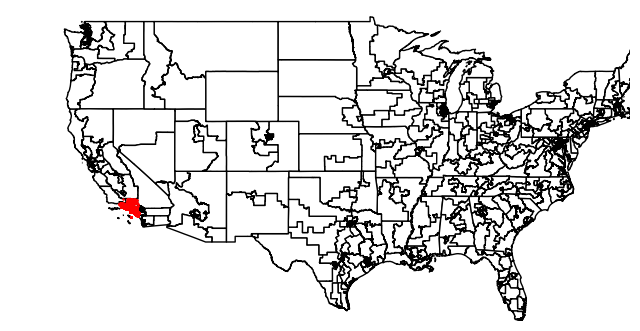

In [5]:
usaMap = gpd.read_file(const["usaMap"]["path"])
ax     = usaMap.plot(color = 'white', edgecolor = 'black', figsize = (8, 5))
houses.plot(ax = ax, color = 'red', marker = '.', markersize = 1)
plt.xlim([-130, -70])
plt.ylim([25, 50])
plt.axis('off')
plt.show()

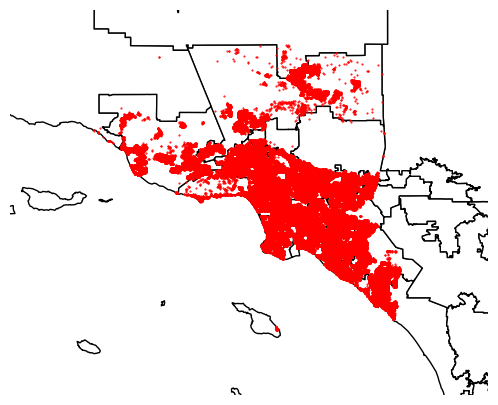

In [45]:
ax = usaMap.plot(color = 'white', edgecolor = 'black', figsize = (8, 5))
houses.plot(ax = ax, color = 'red', marker = '.', markersize = 1)

plt.xlim([-120, -117])
plt.ylim([33, 35])
plt.axis('off')
plt.show()

The following comes from [here](https://geographicdata.science/book/notebooks/12_feature_engineering.html#).

### Points of Interest (POIs) near each property
Let's extract several points of interest from OpenStreetMap for the regions covered on the dataset. Available options can be found [here](https://wiki.openstreetmap.org/wiki/Map_features).

In [27]:
# Get an (enlarged) convex hull of all propertes in the dataset
hull = houses["geometry"].unary_union.convex_hull.buffer(
    distance = const["points_of_interest"]["buffer_distance"]
    )

# Get OSM features for this region (this will take a while depending on the internet connection)
pois = ox.features.features_from_polygon(polygon = hull, tags = const["points_of_interest"]["tags"])

We can engineer multiple features from the point-of-interest (POIs), for example how many bars or restaurants exist within 500 meters of each house, what's the distane to the closes POI of a certain type, etc.

In [29]:
tags   = const["points_of_interest"]["tags"]
types  = list(const["points_of_interest"]["tags"].keys())
radius = const["points_of_interest"]["radius"]

# Make boolean indicator with POI type
poiTypes = gpd.GeoDataFrame(
    pois[types].notnull()
).set_geometry(pois["geometry"])

# Count POIs within a given radius of each property
poiCounts = features.countPOIs(
    houses["geometry"], poiTypes,
    radius = radius, 
    epsg   = const["epsg"]
)

# Get nearest POIs per property
nearestPOIs = features.nearPOIs(houses["geometry"], pois, tags, const["epsg"])

The resulting Series is indexed on the property IDs, so we can assign it to the original tadataframe. In this case, we know by construction that missing properties in poi_count do not have any POI within 500m, so we can fill missing values in the column with zeros when merging. 

### Elevation

From the [portal](https://lpdaac.usgs.gov/products/nasadem_scv001/) that provides data access we can figure out which parts of the dataset (which has global coverage) we need from NASA's Earthdata search tool, and we can download these parts from the Data Pool for free. Both these tools can be found under the "Access Data" tab of the portal.

For this dataset, the files we need are:

* NASADEM_HGT_n34w120.zip
* NASADEM_HGT_n34w119.zip
* NASADEM_HGT_n34w118.zip
* NASADEM_HGT_n33w120.zip
* NASADEM_HGT_n33w119.zip
* NASADEM_HGT_n33w118.zip

Note that a username and a password is required ot download. Registration is free via this [link](https://urs.earthdata.nasa.gov/).

In [188]:
for url in const["nasadem"]["urls"]:

    # Retain the name of the zipfile
    _, filename = os.path.split(url)

    # make full path
    filepath = os.path.join(const["nasadem"]["folder"], filename)
    
    # Download file
    !wget --user xxxxxx --password yyyyy {url} -O {filepath}

    # Extract the hgt file from the zip archive
    zipFile  = zipfile.ZipFile(filepath, "r")
    filename = filepath.strip("NASADEM_HGT_").strip(".zip")
    zipFile.extract(filename + ".hgt")
    zipFile.close()
    

The commands below merge the various .hgt files into one .tiff file for convenience

In [ ]:
# Wildcard for all .hgt files in the folder
wildcard = os.path.join(const["nasadem"]["folder"], '*.hgt')

# Make the map (.tiff file)
!rio merge -f GTIFF {wildcard} {const["nasadem"]["map"]}

# Cleanup
!rm {wildcard}

Now, we can extract elevation directly:

In [41]:
elevation = features.getElevation(houses["geometry"], const["nasadem"]["map"])

Let's plot everything up to this point:

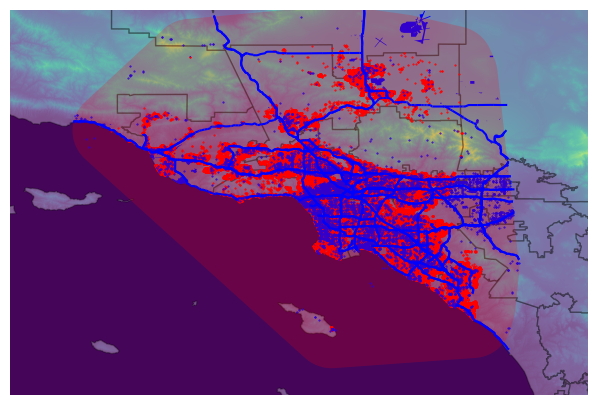

In [ ]:
# Read file
dem = rio.open(const["nasadem"]["map"])

# Plot all layers
ax = usaMap.plot(color = 'white', edgecolor = 'black', figsize = (8, 5), alpha = 0.3) # Map
houses.plot(ax = ax, color = 'red', marker = '.', markersize = 1) # Houses
pois.plot(ax = ax, color = 'blue', marker = '.', markersize = 1)  # POIs          
xs, ys = hull.exterior.xy # Enlarged convex hull
ax.fill(xs, ys, alpha=0.2, fc='r', ec='none')
rioshow(dem, ax = ax) # Elevation

plt.xlim([-120, -117])
plt.ylim([33, 35])
plt.axis('off')
plt.show()
 

### Census data

We can also include the population density of the neighborhood at which each house is located using cenpy.

We can get an impression of the neighborhood using the following variables:

| Name |Code|
| :---------------- | :------: |
UNWEIGHTED SAMPLE COUNT OF THE POPULATION | B00001_001E|
UNWEIGHTED SAMPLE HOUSING UNITS | B00002_001E|
AGGREGGATE INCOME IN THE PAST 12 MONTHS | B19313_001E|

In [ ]:
# The following function produces warnings due to the way the cenpy package
# uses pandas. It can be safely ignored.
censusData = features.getCensus(
    const["census"]["year"], const["census"]["places"], const["census"]["variables"]
    )

# Convert to densities (per unit of area)
areas = censusData.area
for var in const["census"]["variables"]:
    censusData[var] /= areas

# Map the extracted features to the corresponding properties
censusMapped = features.map(censusData, to = houses["geometry"])

# Remove unnecessary fields 
censusMapped = censusMapped[const["census"]["variables"]]

### City-based features

Furthermore, we can extract the following:
* The name of the nearest city.
* The distance from the district's coordinates to the nearest city.
* The population of the nearest city.
* The nearest 'big city' (a big city is categorized as > 250,000 residents in the given year).
* The distance to the nearest 'big city'.

Using osmnx we will also retrieve OSM elements with the Nominatim API. Note that this does not extract the "city center" in the colloquial sense of the word. Rather, it returns (among other data) the geometric centroid of the cities cosindering their boundaries.

First get the population estimates or all cities in the state of California:

In [ ]:
!wget {const["cities"]["url"]} -O {const["cities"]["file"]}

--2023-12-11 14:45:34--  https://www2.census.gov/programs-surveys/popest/tables/2010-2019/counties/totals/co-est2019-annres-06.xlsx
Resolving www2.census.gov (www2.census.gov)... 23.192.48.75, 2600:1400:11:18b::208c, 2600:1400:11:199::208c
Connecting to www2.census.gov (www2.census.gov)|23.192.48.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17399 (17K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘../data/zillow_houseprice/population_estimates_california.xlsx’

../data/zillow_hous 100%[===================>]  16.99K  --.-KB/s    in 0s      

2023-12-11 14:45:35 (204 MB/s) - ‘../data/zillow_houseprice/population_estimates_california.xlsx’ saved [17399/17399]



In [ ]:
# Get population function
pop = (
    pd.read_excel(const["cities"]["file"], header = 3)
    .dropna(how = "any", axis = 0)  # Remove final rows that contain irrelevant notes
    [["Unnamed: 0", const["census"]["year"]]] # Keep only relevant columns
)

pop.columns = ["city", "population"] # Fix column names
pop["city"] = ( 
    pop["city"]
    .str.replace(" city", "") # Remove the word "city"
    .str.replace(" town", "") # Remove the word "town"
)

# Extract geometries from osmnx
cities = ox.geocode_to_gdf( # Extract geometries from osmnx
    pop["city"].tolist(), which_result = 0
    )

# Add population and keep only the useful columns
cities["population"] = pop["population"] 
cities = cities[["geometry", "name", "population"]]

# For some reason the results contain Los Angeles twice.
cities.drop(11, axis = 0, inplace = True)

# Remove counties
isCounty = cities["name"].str.lower().str.contains("county")
cities   = cities[~isCounty]

Let's plot the new data:

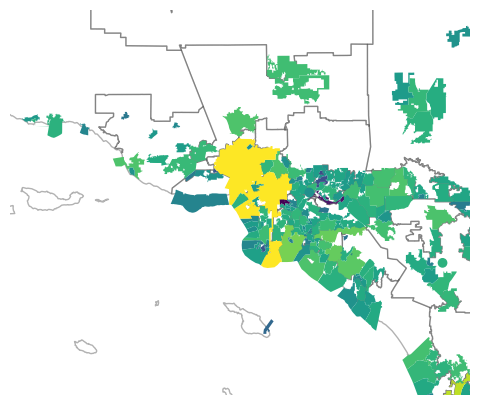

In [ ]:
ax   = usaMap.plot(color = 'white', edgecolor = 'black', figsize = (8, 5), alpha = 0.3)
norm = LogNorm(vmin = cities["population"].min(), vmax = cities["population"].max())
cities.to_crs(houses.crs).plot(ax = ax, norm = norm, column = "population")

plt.xlim([-120, -117])
plt.ylim([33, 35])
plt.axis('off')
plt.show()


We can extract the required features:

In [ ]:

# Extract the "big" cities out of the results
ix = cities["population"] > const["cityPopulation"]
bigCities = cities[ix]

# Evaluate the nearest cities to each property
citydfs = []
for citydf in [cities, bigCities]:

    nearest = features.getNearest(
        from_ = citydf, 
        to_   = houses, 
        ties  = "population", 
        epsg  = const["epsg"],
        ascending = False, 
        )
    
    # Keep only relevant columns and append to list
    nearest = nearest[["name", "population", "distance"]]
    citydfs.append(nearest)

# Merge all
suffixes   = ["_close_city", "_close_big_city"]
nearCities = pd.merge(citydfs[0],  citydfs[1], left_index  = True, right_index = True, suffixes = suffixes)

#### Merge all

In [ ]:
newFeatures = pd.concat(
    [elevation, poiCounts, censusMapped, nearCities, nearestPOIs], 
    axis = 1
    )

In [ ]:
continuousCols  = [col for col, dtype in zip(newFeatures.columns, newFeatures.dtypes) if not dtype == object]
categoricalCols = [col for col in newFeatures.columns if col not in continuousCols]

print(f"{len(continuousCols)} numerical features were extracted")
print(f"{len(categoricalCols)} categorical features were extracted")

25 numerical features were extracted
2 categorical features were extracted


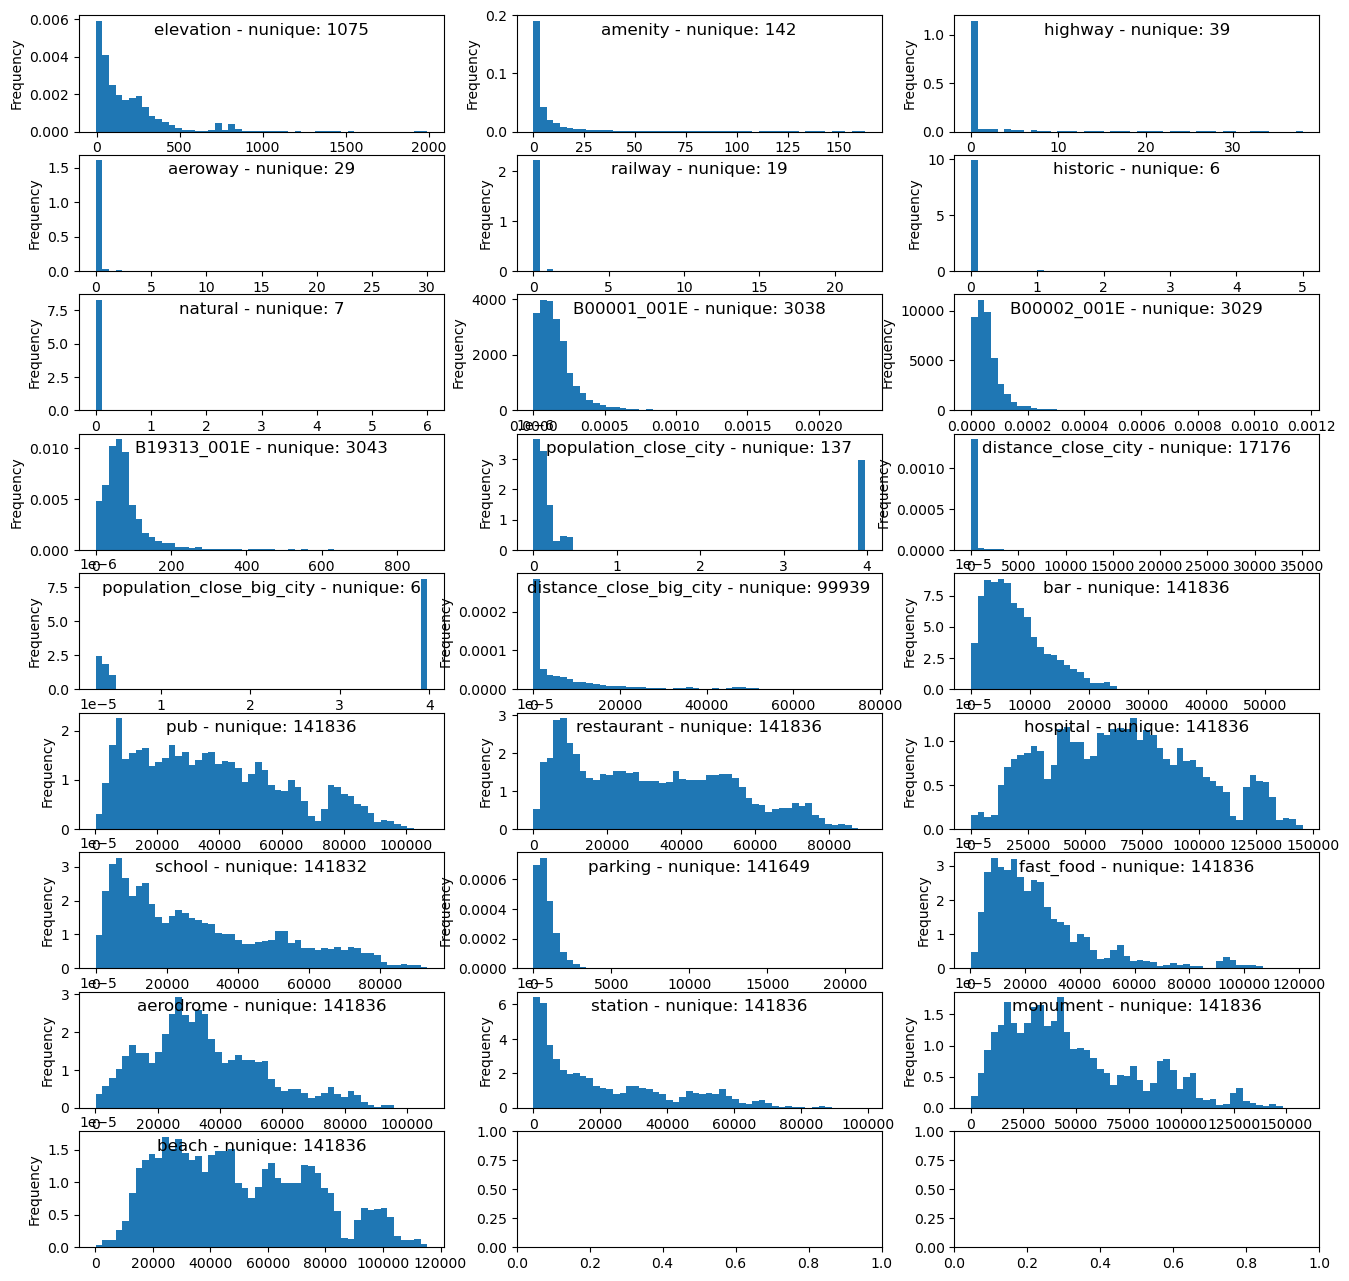

In [ ]:
fig, axes = plt.subplots(nrows = 9, ncols = 3, figsize = (16, 16), sharex = False)

for ax, col in zip(axes.flat, continuousCols):
    title = " - ".join([col, f"nunique: {newFeatures[col].nunique()}"] )
    newFeatures[col].plot.hist(ax = ax, bins = 50, density = True)
    ax.set_title(title, y=1.0, pad = -14)

### Correlations

In [ ]:

# Correlation matrix
corrMat = newFeatures[continuousCols].corr(method = "spearman").abs()

# Set half to null
mask = np.zeros_like(corrMat, dtype = bool)
mask[np.tril_indices_from(mask)] = True
corrMat[mask] = np.nan

# Get highest correlations
(
    corrMat
    .unstack()
    .dropna()
    .sort_values(kind="quicksort", ascending = False)
    .iloc[0:15]
)


B00002_001E  B00001_001E                  0.958829
school       pub                          0.933772
beach        restaurant                   0.923616
             school                       0.907595
station      pub                          0.882418
restaurant   pub                          0.872852
school       restaurant                   0.867328
hospital     population_close_big_city    0.865783
beach        pub                          0.857949
station      aerodrome                    0.840376
beach        hospital                     0.837857
monument     hospital                     0.814815
             fast_food                    0.801833
aerodrome    pub                          0.791964
station      school                       0.787437
dtype: float64

We can remove:
* B00002_001E
* pub

In [ ]:
newFeatures.drop(["B00002_001E", "pub"], axis = 1, inplace = True)

Write to file:

In [ ]:
newFeatures.to_csv(config["features_file"])

Considering the above, the following post-processing must be performed on the new features:

* Log(x): elevation, amenity, B00001_001E, B19313_001E, distance_close_city, distance_close_big_city,  population_close_city, population_close_big_city.
* Sqrt(x): bar, restaurant, school, aerodrome, monument
* x ** (1/3): fast_food, parking, station, 
* highway, aeroway, railway, historic, natural: Make additional binary variables with the rule: value > 0
* After log transform:
    * distance_close_city: additional binary variable with the rule: value > -2
    * distance_close_big_city: additional binary variable with the rule: value > -3
    * population_close_city, population_close_big_city: additional binary variables with the rule: value > 0
* Fill nans: All will be filled with mean values
* name_close_big_city: One-hot encode
* name_close_city: High-dimensional. Use in feature hasher.